In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("dir/Diffusion")
print("Changed directory to:", os.getcwd())  # Verify the change

Changed directory to: /content/drive/MyDrive/Hari/Evaluation/Diffusion


In [ ]:
os.chdir("dir/Diffusion/")
sys.path.append(os.path.abspath("src"))
#from npy_npz import save_to_npz
from dataset import LensingDataset
from dataset2 import LensingDataset2
from train import train
from noise_scheduler import LinNoiseScheduler
from model_unet import Unet

In [ ]:
dataset = LensingDataset("dir/Diffusion/data/samples.npz")

In [ ]:
dataset_ = []

In [ ]:
for i in dataset:
  i = i.unsqueeze(1)
  i = F.interpolate(i, size=(28), mode='bilinear', align_corners=False)
  i = i.squeeze(1)
  dataset_.append(i)

In [ ]:
print(dataset_[0].shape)

torch.Size([1, 28, 28])


ORIGINAL IMAGE:

torch.Size([1, 150, 150])


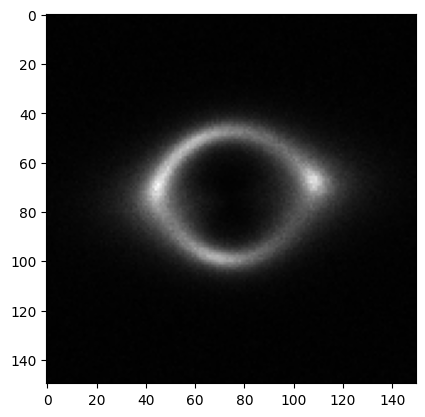

In [ ]:
print(dataset[0].shape)
plt.imshow(np.transpose(dataset[0],(1,2,0)),cmap='gray')

IMAGE WITH SPATIAL DIMENSION DOWNSCALED TO 28 FROM 150

torch.Size([1, 28, 28])


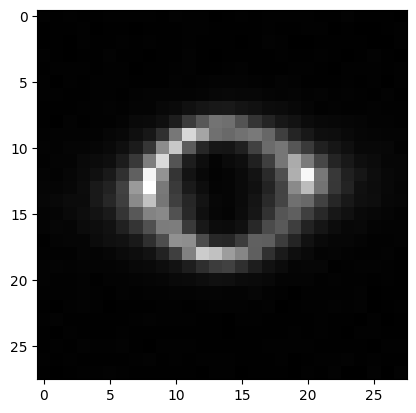

In [ ]:
print(dataset_[0].shape)
plt.imshow(np.transpose(dataset_[0],(1,2,0)),cmap='gray')

In [ ]:
model = Unet(im_channels=1)

torch.Size([1, 28, 28])


/content/drive/MyDrive/Hari/Evaluation/Diffusion/src/data_reshape.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data_list[idx], dtype=torch.float32)  # Convert to tensor


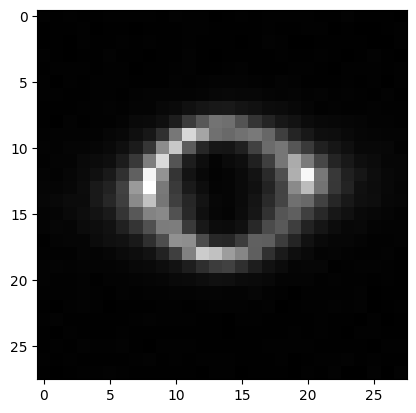

In [ ]:
from data_reshape import ListDataset
# Wrap it in a Dataset
dataset2 = ListDataset(dataset_)
print(dataset2[0].shape)
plt.imshow(np.transpose(dataset2[0],(1,2,0)),cmap='gray')

Now we have two dataset classes having images of strong lensing in two different spatial dimensions. We will first train the model on the second set holding images with spatial dimensions of 28x28. This will take lesser compute.

In [ ]:
# Create DataLoader
dataloader = DataLoader(dataset2, batch_size=10, shuffle=True)
print(len(dataset2))
# Iterate through batches
for batch in dataloader:
    print(batch.shape)
    break  # Expected: torch.Size([10, 1, 28, 28])


10000
torch.Size([10, 1, 28, 28])


In [ ]:
epochs = 40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scheduler = LinNoiseScheduler(num_of_timesteps=1000,beta_start=0.0001,beta_end=0.02)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train(dataloader, model, epochs, scheduler, lr=1e-4, ckpt_name="model_checkpoint.pth", save_dir="./results")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

    # Load model with checkpoint
model2 = Unet(im_channels =1).to(device)
model2.load_state_dict(torch.load("/content/drive/MyDrive/Hari/Evaluation/Diffusion/results/model_checkpoint.pth"), map_location=device)
model.eval()

    # Create the noise scheduler
scheduler = LinNoiseScheduler(num_timesteps=1000,beta_start=0.0001,beta_end = 0.02)
with torch.no_grad():
  sample(model, scheduler)

SAMPLED IMAGE GRIDS CAN BE FOUND AT "./results/train_1", FOR 100 SAMPLES , AT ECAH TIMESTEP WE STORE A GRID AS A PNG IMAGE SHOWING ALL THE 100 IMAGES AT THAT PARTICULAR TIMESTEP. LATER IN SAMPLE_2, AND SAMPLE_3, I HAVE SAVED INDIVIDUAL IMAGES BOTH IN THE NATURAL GENERATED DIMENSIONS AND UPSCALED TO 150 SPATIAL DIMENSIONS, CHECK NOTEBOOKS "./notebooks/Sample_2.ipynb" and "./notebooks/Sample_3.ipynb". Infact, the sampling process for the grids is in notebook "./notebooks/Sample_1.ipynb"